## Anisotropic heterogeneous wave equation

This tutorial aims at illustrating the use of the Partitioned Finite Element Method (PFEM) (Cardoso-Ribeiro et al, 2018) to discretize a port-Hamiltonian system (pHs) related to the simulation of the two-dimensional anisotropic heterogeneous wave equation with boundary damping. We specifically learn how to define and solve this problem with Scrimp. 

We first define the continuous problem. Then we tackle the semi-discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a pHODE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import Scrimp
from math import pi

Could not find GLIMDA.


## Problem statement


We consider the two-dimensional heterogeneous anisotropic wave equation with fluid internal damping and impedance boundary condition defined for all $t\ge 0$ as

$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\,\displaystyle \frac{\partial^2}{\partial t^2} w(t,\boldsymbol x) - \text{div}\Big(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)\Big) &=& \displaystyle-\varepsilon(\boldsymbol x)\frac{\partial}{\partial t}w(t,\boldsymbol x)  , \quad \boldsymbol x \in \Omega, \\
    Z(\boldsymbol x)~(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)) \cdot {\bf{n}} + 
    {\partial_t} w(t,\boldsymbol x) & = & 0, \quad \boldsymbol x \in \partial \Omega, \\ 
    w(0, \boldsymbol x) & = & w_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
    {\partial_t} w(0,\boldsymbol x) & = & w_1(x), \quad \boldsymbol x \in \Omega, t=0, \\
\end{array}
$$

with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 
In this tutorial we consider a rectangular shaped domain for $\Omega$. $w(t,\boldsymbol x)$ denotes the deflection from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline T} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the Young's elasticity modulus, $\varepsilon(\boldsymbol x)$ is the positive fluid damping coefficient, and $Z(\boldsymbol x)$ is the positive impedance function defined on $\partial \Omega$. 


## Port-Hamiltonian formulation 

We introduce the energy variables (strain and linear momentum, respectively) as

$$
\boldsymbol \alpha_q = \textbf{grad} \ w(t,\boldsymbol x), \quad 
\alpha_p = \rho~{\partial_t} w(t,\boldsymbol x),
$$ 

the Hamiltonian (total mechanical energy) as

$$
\mathcal{H} = \frac{1}{2} \int_{\Omega} {\boldsymbol \alpha_q}^T . \overline{\overline T}(\boldsymbol x) . \boldsymbol \alpha_q  + \alpha_p \frac{1}{\rho} \alpha_p~dx
$$

and the co-energy variables (stress and velocity, respectively) as

$$
e_q = \partial_{\boldsymbol \alpha_q} \mathcal{H} = \overline{\overline T}(\boldsymbol x) . \boldsymbol \alpha_q, \quad 
e_p = \partial_{\alpha_p} \mathcal{H} = \frac{1}{\rho} \alpha_p,
$$

with $\partial_{\alpha_p}$ denoting the variational derivative with respect to the variable $\alpha_p$. The infinite-dimensional port-Hamiltonian system can then be written as

\begin{eqnarray*}
\partial_t \left \lbrack 
\begin{array}{c}
\boldsymbol \alpha_q \\
\alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
0  & \textbf{grad} \\
div & -\varepsilon \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
e_q \\
e_p 
\end{array}
\right \rbrack, \quad u_{\partial} = e_{p_{|\delta \Omega}} \quad y_{\partial} = e_q . n_{|\delta \Omega}.
\end{eqnarray*}

With the output-feedback law $u_{\partial} = -Z y_{\partial}$, we deduce the relation

$$
Z e_q.n_{|\delta \Omega} + e_{p_{|\delta \Omega}} = 0. 
$$

The existence and uniqueness of the solution of the port-Hamiltonian system is ensured
provided that ${\boldsymbol \alpha_q} \in \overline{\overline T}^{~-1} H^{div}(\Omega)$ and $
\alpha_p \in \rho H^1(\Omega)$ where

$$
\overline{\overline T}^{~-1} H^{div}(\Omega) = \left \lbrace \boldsymbol{v}_q \in L^2(\Omega), div(\overline{\overline T}^{~-1} v_q) \in L^2(\Omega) \right \rbrace,
\rho H^1(\Omega) = \left \lbrace v_p \in L^2(\Omega), {\boldsymbol{grad}}(\rho v_p) \in L^2(\Omega) \right \rbrace.
$$

## Setup

We initialize here the Python object related to the Wave_2D class of Scrimp. This object will be used throughout this 
tutorial. 

In [2]:
W = Scrimp.Wave_2D()

### Constants

We define the constants related to the definition of the rectangular domain $\Omega$. The coordinates of the left bottom ($x_0, y_0$) and the right top ($x_L, y_L$) corners of the rectangle are required. 

In [3]:
x0, xL, y0, yL = 0., 2., 0., 1.

We then define the time interval related to the time discretization. $t_i, t_f$ denote the initial and final time instants respectively. 

In [4]:
ti, tf  = 0., 5.

We specify that we choose the external library "Assimulo" to be used later for the time integration of the resulting ordinary differential equation and provide the value of the time step. This should be considered as a reference value since adaptative methods in time can be used later. 

In [5]:
dt           = 1.e-3
ode_library  = 'ODE:Assimulo'

### FEniCS expressions definition

For the finite element discretization of the spatial port-Hamiltonian formulation, the FEniCS library is used in the Wave_2D class of Scrimp. Hence to properly use FEniCS expression definition, we provide the definition of the different variables in C++ code given in strings. We first specify the mass density as a function depending on the space coordinates. Hence in this expression, x[0] corresponds to the first spatial variable and x[1] to the second one, respectively.

In [6]:
Rho    = 'x[0]*x[0] * (2.-x[0])+ 1'

We specify the Young's elasticity modulus tensor. Three components are only required due to the symmetry property of this tensor. 

In [7]:
T11    = 'x[0]*x[0]+1'
T12    = 'x[1]'
T22    = 'x[0]+2'

We finally specify the impedance function $Z$ defined on the boundary of the domain. Here a constant value is used on $\partial \Omega$. We also provide the viscous damping parameter function (eps).

In [8]:
Z   = '0.1'
eps = '25 * x[0] * (xL-x[0]) * x[1] * (yL-x[1])'

We specify the initial conditions of the problem related to the deflection and to the energy variables.

In [9]:
Aq_0_1= '0'
Aq_0_2= '0'
Ap_0  = '0'
W_0   = '0'

## Problem at the continuous level

We are now able to completely define the problem at the continuous level. We start by specifying that the computational domain $\Omega$ is of rectangular shape. To define $\Omega$, we provide the coordinates of the bottom left and up right corners to the Wave_2D object.

In [10]:
W.Set_Rectangular_Domain(x0, xL, y0, yL);

We provide next the time integration interval. 

In [11]:
W.Set_Initial_Final_Time(ti, tf);

We then provide the physical parameters related to the wave equation: the mass density, the Young's elasticity modulus tensor and the impendance function, respectively.

In [12]:
W.Set_Physical_Parameters(Rho, T11, T12, T22);

We then specify the complete modelling for the damping and thus provide information related to the impedance function, viscous damping parameter and components of the viscoelastic tensor. 

In [13]:
W.Set_Damping(damp=['impedance', 'fluid'], Z=Z, eps=eps);

----------------------------------------
Damping: impedance,  fluid
Damping: OK
----------------------------------------


We provide the space and time parts of the boundary control function. The complete boundary control function is then the product of both functions. 

In [14]:
W.Set_Boundary_Control(Ub_tm0=lambda t:  np.sin( 2 * 2*pi/tf *t) * 25 , Ub_sp0='x[0] * x[1] * (1-x[1])');

----------------------------------------
Boundary control: OK
----------------------------------------


Finally we provide the initial conditions for the time-dependent ordinary system.

In [15]:
W.Set_Initial_Data(Aq_0_1='0', Aq_0_2='0', Ap_0='0', W_0='0');

We finally check that the continuous problem has been completely defined. 

In [16]:
assert W.Check_Problem_Definition() == 1, "Problem definition to be checked again !"

## Problem at the discrete level in space and time

We use the Partitioned Finite Element Method to obtain the semi-discretization in space of the port-Hamiltonian system. 

The structure preserving discretization of the open-loop infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail \cite{}. Formally we obtain a pHs of the following type

\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
\underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
0  & D \\
-D^T & -R_\varepsilon \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
\underline e_q \\
\underline e_p 
\end{array} 
\right \rbrack +
\left \lbrack
\begin{array}{c}
B \\
0 
\end{array} 
\right \rbrack
\underline u_{\partial}, \\
M_{\partial} ~ \underline{y}_{\partial} & = & B^T \underline e_q.
\end{eqnarray*}

The structure preserving discretization of the closed-loop infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail in \cite{}. We then discretize the output-feedback law to take into account the impedance boundary condition and formally obtain a dissipative pHs of the following type

\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
\underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
-R_Z  & D \\
-D^T & -R_\varepsilon \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
\underline e_q \\
\underline e_p 
\end{array}
\right \rbrack,
\end{eqnarray*}

or equivalently


\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
 \underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
-R_Z  & D \\
-D^T & -R_\varepsilon \\
\end{array}
\right \rbrack
\left \lbrack 
\begin{array}{cc}
 \underline{\overline{\overline T}(\boldsymbol x)}  & 0 \\
0                                      & \underline {\displaystyle \frac{1}{\rho}} \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
 \boldsymbol {\underline \alpha_q}  \\
 \underline \alpha_p 
\end{array}
\right \rbrack,
\end{eqnarray*}


with $R_Z = B M_{\partial}^{-1} M_z M_{\partial}^{-1} B^T$ and given initial conditions on both $\boldsymbol {\alpha_q}$ and $\alpha_p$ respectively. This leads to the following compact discrete formulation

$$
M ~\partial_t \boldsymbol {\underline \alpha} = (J-R)~Q~ \boldsymbol {\underline \alpha},
$$
with 
\begin{eqnarray*}
M & = &
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack, \quad 
J = 
\left \lbrack 
\begin{array}{cc}
0  & D \\
-D^T & 0 \\
\end{array}
\right \rbrack, \quad
R = 
\left \lbrack 
\begin{array}{cc}
R_Z  & 0 \\
0 & R_\varepsilon \\
\end{array}
\right \rbrack, \quad
Q = 
\left \lbrack 
\begin{array}{cc}
 \underline{\overline{\overline T}(\boldsymbol x)}  & 0 \\
0                                      & \underline {\displaystyle \frac{1}{\rho}} \\
\end{array}
\right \rbrack.
\end{eqnarray*} 

We start by selecting the computational mesh which is generated with Gmsh. The parameter rfn_num corresponds to a mesh refinement parameter.

In [17]:
W.Set_Gmsh_Mesh('rectangle.xml', rfn_num=2);

----------------------------------------
Mesh: hmax= 0.168 Nv= 201
Mesh: OK
----------------------------------------


To perform the discretization in space, we must first specify the conforming finite element approximation spaces to be used. Concerning the energy variables associated with the strain, we select the Raviart-Thomas finite element family known as $RT_k$ consisting of vector functions with a continuous normal component across the interfaces between the elements of a mesh. For the energy variables associated with the linear momentum and the boundary variables, we choose the classical $P_k$ finite element approximation. The given combination of parameters rt_order=0, p_order=1, b_order=1 corresponds to the $RT_0 P_1 P_1$ family. 

In [18]:
W.Set_Finite_Element_Spaces(family_q='RT', family_p='P', family_b='P',rq=0, rp=1, rb=1);

----------------------------------------
Vq= RT_0 ,	 Vp= P_1 ,	 Vb= P_1
Nq= 552 ,	 Np= 201 ,	 Nb= 48
DOFsys= 753
FE spaces: OK
----------------------------------------


We then perform the semi-discretization in space of the weak formulation with PFEM. At the end of this stage, the complete formulation of the pHODE is obtained. The different matrices related to the pHODE system are constructed in the Assembly method of the Wave_2D class of Scrimp and are directly accessible through the object of the Wave_2D class as used later in this tutorial. The finite element assembly relies on the variational formulation of PFEM and exploits the level of abstraction provided by the unified form language (UFL) used in FEniCS, leading to a code that is close to the mathematical formulation. The Div formulation is selected leading to a pHODE system. 

In [19]:
W.Assembly(formulation='Div');

To perform the time integration of the pHODE, we first need to interpolate both the control function on the boundary and the initial data on the appropriate finite element spaces. 

In [20]:
W.Project_Boundary_Control()
W.Project_Initial_Data();

----------------------------------------
Project BC: OK
Project initial data: OK
----------------------------------------


Then we specify the parameters related to the time discretization.

In [21]:
W.Set_Time_Setting(dt);

We finally check that the space-time discrete problem has been completely defined. 

In [22]:
assert W.Check_Space_Time_Discretization() == 1, "Space and time discretization to be checked again !"

## Numerical approximation of the space-time solution

Now we perform the time integration of the resulting pHODE system and deduce the behaviour of the energy variables, the Hamiltonian and the deflection with respect to the time and space variables, respectively. Detailed information from the Assimulo library is provided after time integration.

In [23]:
A, Hamiltonian = W.Time_Integration(ode_library)

ODE Integration using assimulo built-in functions:
Final Run Statistics: --- 

 Number of steps                                 : 757
 Number of function evaluations                  : 1124
 Number of Jacobian*vector evaluations           : 1451
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 1121
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : SPGMR
 Maximal order            : 3
 Tolerances (absolute)    : 1e-05
 Tolerances (relative)    : 1e-05

Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.7060859180019179 seconds.


Time integration completed !
---------------------------------------- 



## Post-processing

We represent the two-dimensional mesh with corresponding degrees of freedom for each variable. 

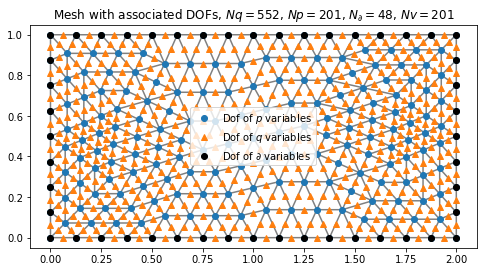

In [24]:
W.notebook = True
W.Plot_Mesh_with_DOFs()    

We plot the Hamiltonian function versus time. tspan is the collection of discrete times due to the possibly adaptative time procedure used in the time integration library.

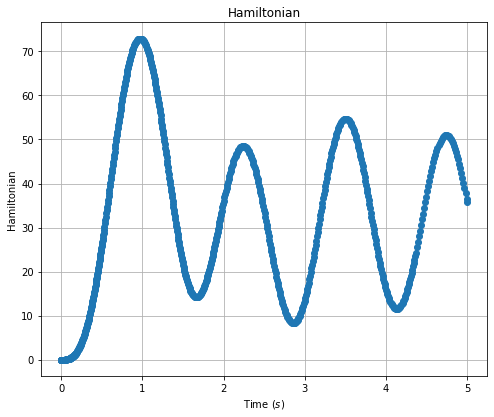

In [25]:
W.Plot_Hamiltonian(W.tspan,Hamiltonian, marker='o')

The behaviour of the deflection can be graphically represented at a given time. Here we simply plot the deflection at the final time of the simulation. 

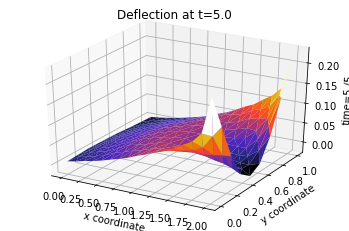

In [26]:
W.Plot_3D(W.Get_Deflection(A), tf, 'Deflection at t='+str(tf))

Furthermore the time evolution of the deflection can be obtained as a movie file by setting the movie boolean variable to True.

In [27]:
movie = False
if movie:
    %matplotlib tk
    W.Set_Video_Writer()
    W.Moving_Trisurf(W.Get_Deflection(A), 1, 'Deflection_versus_time', save=True)
    %matplotlib inline

In [28]:
movie = False
step  = 50
if movie :
    %matplotlib tk
    W.Set_Video_Writer()
    W.Moving_Trisurf(W.Get_Deflection(A), step=step, title='Deflection', figsize=(18,7.5), cmap=plt.cm.plasma)#, save=True)
    W.Moving_Trisurf(W.Get_Linear_Momentum(A), step=step, title='Linear momentum', cmap=plt.cm.plasma)#, figsize=(20,7.5) )#, save=True)
    #W.Moving_Quiver(W.Get_Strain(A), step=step, title='Strain', figsize=(15,7.5), cmap=plt.cm.plasma)#, save=True)               
    W.Moving_Plot(Hamiltonian, W.tspan,  step=step, title='Hamiltonian', figsize=(8,7.5), save=True)
    %matplotlib inline

## Model reduction of the original port-Hamiltonian system

Given the linear port-Hamiltonian system obtained previously, we illustrate how to perform model reduction within Scrimp. Hence we adopt the model reduction algorithm (Algorithm 1) proposed in Chaturantabut et al, 2016 to derive a reduced structure-preserving port-Hamiltonian system. We first perform the truncated singular value decomposition of the so called snapshot matrices related to the time evolution of the original system. Then we learn how to properly construct the reduced port-Hamiltonian system inside Scrimp. Finally, we perform an analysis of the generalized eigenvalue problem of both the original and reduced models.

###  Singular Value Decomposition of the snapshot matrices

We first define the snapshot matrix related to the energy variable. We are interested in the model reduction of the 
dissipative pHODE system after a given time in the simulation. We store the corresponding time evolution of the energy variable of our pHODE system in the X variable.

In [29]:
Aq = A[:W.Nq,:]
Ap = A[W.Nq:,:] 
X  = np.concatenate((Aq[:,200:], Ap[:,200:])) 

We deduce the co-energy snapshot matrix named F by performing a matrix multiplication with the Q matrix. 

In [30]:
Q = np.eye(X.shape[0])
F = Q @ X

Given these two snapshot matrices, we are ready to create the model reduction object named MR issued from the Model_Reduction class of Scrimp.

In [31]:
MR = Scrimp.Model_Reduction(X, F)

The projection used in the model reduction algorithm is performed in a weighted inner product defined by the (non singular) block diagonal mass matrix of the pHODE system. Hence we provide this matrix to the model reduction object MR.

In [32]:
MR.Specify_Weight_Matrix(W.M); 

Next we specify the algorithm to be used for performing the model reduction. Here we rely on the classical truncated Singular Value Decomposition algorithm, i.e. the dimension of the reduced system $r$ is the smallest integer for which both conditions are satisfied $$\displaystyle \frac{\sigma_r(F)}{\sigma_1(F)} < \tau \quad \mbox{and} \quad  \displaystyle \frac{\sigma_r(X)}{\sigma_1(X)} < \tau, $$ where $\tau$ denotes the truncation threshold and $\sigma_i(M)$ the $i$-th singular value of $M$ (the singular values are supposed to be ordered decreasingly).

In [33]:
MR.Specify_POD_Method('SVD')
tau        = 1.e-8
MR.POD_Reduction(tau);

We print $r$ the dimension of the reduced model and plot the singular value decay of the energy and coenergy snapshot matrices, respectively.

In [34]:
print("Dimension of the reduced model:",MR.r)

Dimension of the reduced model: 87


### Plots related to the singular value decay of the snapshot matrices

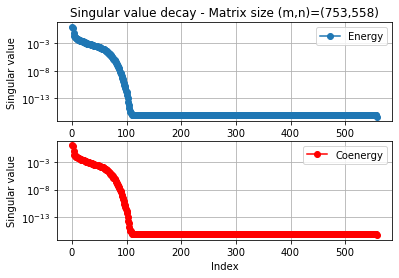

In [35]:
MR.Plot_Decay_Singular_Values();

### Construction of the reduced pHs

Given the approximation subspaces related to the energy and co-energy snapshot matrices obtained as a by-product of the truncated SVD algorithm, we explicitely construct the matrices of the projected system. A Galerkin procedure is used to do so as proposed in Chaturantabut et al, 2016. Note that this projection offers the advantage to be structure-preserving, i.e. the reduced system is also of port-Hamiltonian type.  

In [36]:
(Br, Jr, Qr, Rr, Mr) = MR.Determine_Reduced_Problem(W.Bext, W.J, Q, W.R, W.M)

These matrices can be used later to define the corresponding reduced port-Hamiltonian system to be able to perform e.g. its time integration.

### Eigenvalue analysis

We perform the stabiliy analysis of the reduced and global systems. Hence we solve the generalized eigenvalue problem of both the original and reduced models i.e. we solve $ (J-R)Q v = \lambda M v$ and $ (J_r-R_r) 
Q_r v_r = \lambda_r M_r v_r$, respectively. We plot the spectra related to the stability analysis of the global and reduced problems.

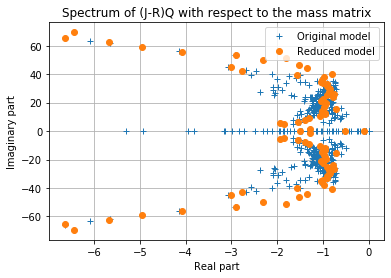

In [37]:
MR.Plot_Spectra(W.J, Q, W.R, W.M, Jr, Qr, Rr, Mr);

The construction of the reduced model is based on the assumption that it is possible to identify subspaces 
that contribute significantly to the system response. See the discussion at the beginning of Section 2 in Chaturantabut et al, 2016. 

Concerning the POD algorithm, it is known that POD can be effective in capturing dynamic features that are present in the original sampled system response. Hence it is incapable of providing information about dynamic response features that are not present in the sampled system response. See the discussion in Section 2.1 of Chaturantabut et al, 2016. 

# Further information

- <a href="https://www.sciencedirect.com/science/article/pii/S2405896318303252">"Structure-preserving Partitioned Finite Element Method for the 2D wave equation"</a> by F. L. Cardoso-Ribeiro, D. Matignon, L. Lefèvre. In IFAC-PapersOnLine, 51 (3), 119–124, 2018.


- <a href="https://epubs.siam.org/doi/abs/10.1137/15M1055085">"Structure-preserving model reduction for nonlinear port-Hamiltonian systems"</a> by S. Chaturantabut, C. Beattie and S. Gugercin, SIAM J. Sci. Comput. 38-5 B837-B865, 2016. 


- <a href="https://www.sciencedirect.com/science/article/pii/S0005109812002257">"Structure-preserving tangential-interpolation based model reduction of port-Hamiltonian Systems."</a> by S. Gugercin, R. V. Polyuga, C. A. Beattie and A. van der Schaft, Automatica, 48 (9), 1963—1974, 2012. 


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303374">"Partitioned Finite Element Method for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous 2D wave equation"</a> by A. Serhani, D. Matignon and G. Haine, IFAC-PapersOnLine, 52 (2), 96-101, 2019. 
